# Proyecto Predicción de Ventas – Series Temporales

El objetivo es predecir las ventas futuras de la empresa para planificar el tamaño del nuevo almacén

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Carga de datos
url = "https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv"
df = pd.read_csv(url)

print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (366, 2)


,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


Lo primero que vemos es una tendencia claramente creciente.

In [4]:
# Convertir fecha y poner como índice
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()
ts = df['sales']

print(f"Total de observaciones: {len(ts)} días")
print(f"Desde: {ts.index[0].date()} → Hasta: {ts.index[-1].date()}")

Total de observaciones: 366 días
Desde: 2022-09-03 → Hasta: 2023-09-03


El tensor de la serie es diario (datos todos los días a la misma hora).

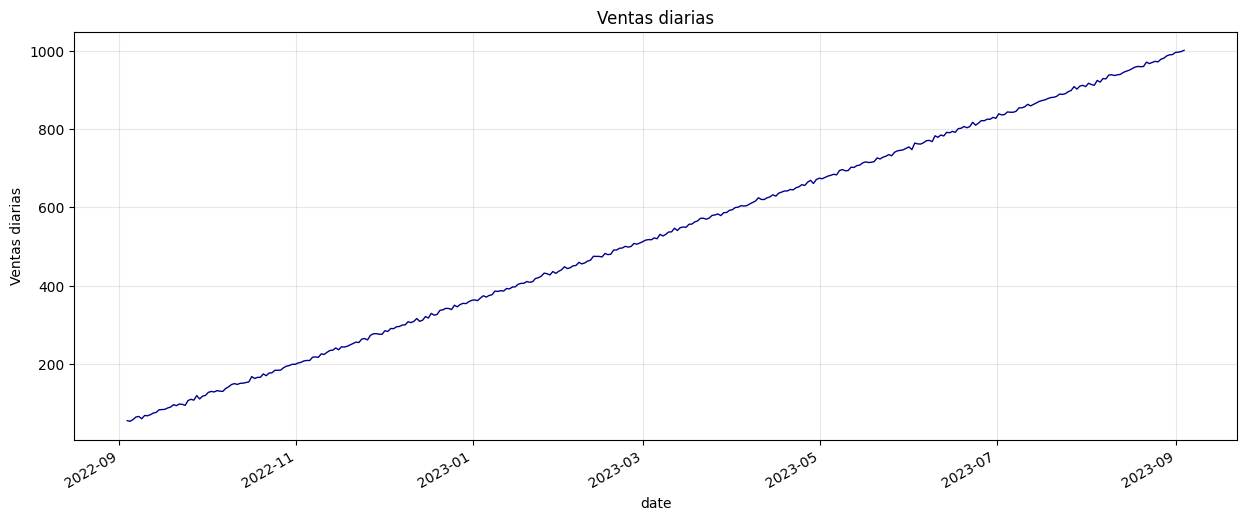

In [5]:
# Grafico de ventas diarias
plt.figure(figsize=(15, 6))
ts.plot(color='darkblue', linewidth=1)
plt.title('Ventas diarias')
plt.ylabel('Ventas diarias')
plt.grid(True, alpha=0.3)
plt.show()

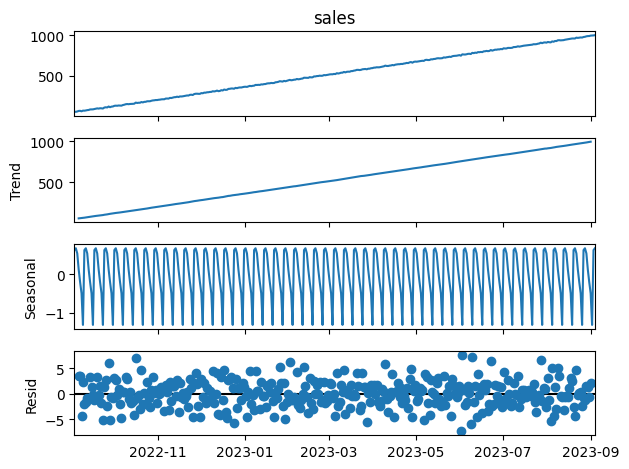

In [18]:
# Descomposición de la serie (tendencia y ruido)
decomp = seasonal_decompose(ts, model='additive')
decomp.plot()
plt.show()

- Tendencia: claramente creciente.
- Estacionalidad: casi inexistente.
- Residuo: algo de ruido aleatorio.

In [7]:
result = adfuller(df["sales"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] < 0.05:
    print("La serie es estacionaria")
else:
    print("La serie no es estacionaria")

ADF Statistic: 0.545414193706378
p-value: 0.9861899815311064
La serie no es estacionaria


In [8]:
# Prueba de estacionalidad (Dickey-Fuller)
result = adfuller(ts)
print(f"ADF Statistic: {result[0]:.3f}")
print(f"p-value: {result[1]:.4f}")

ADF Statistic: 0.545
p-value: 0.9862


p-value mayor que 0.05 → la serie no es estacionaria (como esperábamos por la tendencia).


Después de diferenciar:
ADF Statistic: -9.430
p-value: 0.0000


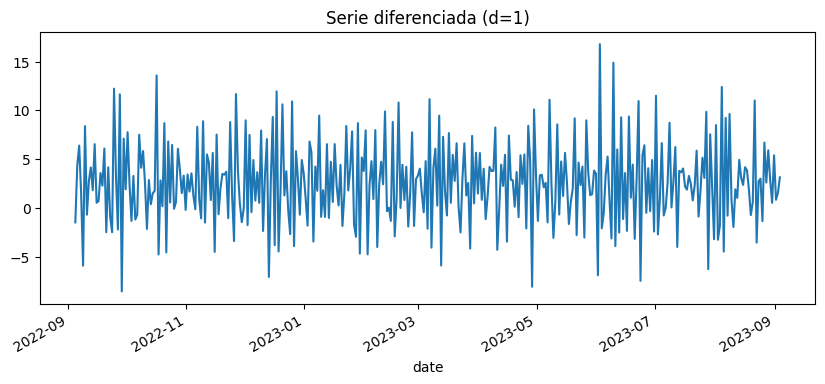

In [9]:
# Diferencia
ts_diff = ts.diff().dropna()

result_diff = adfuller(ts_diff)
print(f"\nDespués de diferenciar:")
print(f"ADF Statistic: {result_diff[0]:.3f}")
print(f"p-value: {result_diff[1]:.4f}")

plt.figure(figsize=(10,4))
ts_diff.plot()
plt.title('Serie diferenciada (d=1)')
plt.show()

Tras una diferenciación, la serie ya es estacionaria (p-value menor que 0.05).
→ d = 1

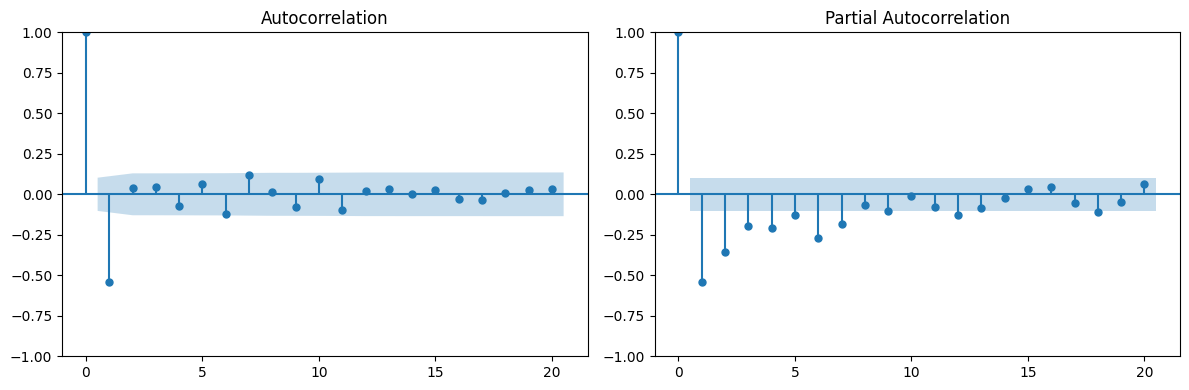

In [10]:
# Graficos para selección de parametros ARIMA
plt.figure(figsize=(12,4))
plt.subplot(121)
plot_acf(ts_diff, lags=20, ax=plt.gca())
plt.subplot(122)
plot_pacf(ts_diff, lags=20, ax=plt.gca())
plt.tight_layout()
plt.show()

- ACF corta rápido: q = 1
- PACF corte en lag 1: p = 1

Probamos ARIMA(1,1,1)

In [11]:
# División train / test
train = ts[:-12]
test = ts[-12:]

print(f"Train: {len(train)} meses")
print(f"Test: {len(test)} meses")

Train: 354 meses
Test: 12 meses


In [12]:
# Entrenamiento modelo ARIMA
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  354
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1019.081
Date:                Wed, 19 Nov 2025   AIC                           2044.161
Time:                        12:33:13   BIC                           2055.761
Sample:                    09-03-2022   HQIC                          2048.777
                         - 08-22-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.002    593.845      0.000       0.997       1.003
ma.L1         -0.9992      0.689     -1.451      0.147      -2.349       0.351
sigma2        18.5995     12.879      1.444      0.1

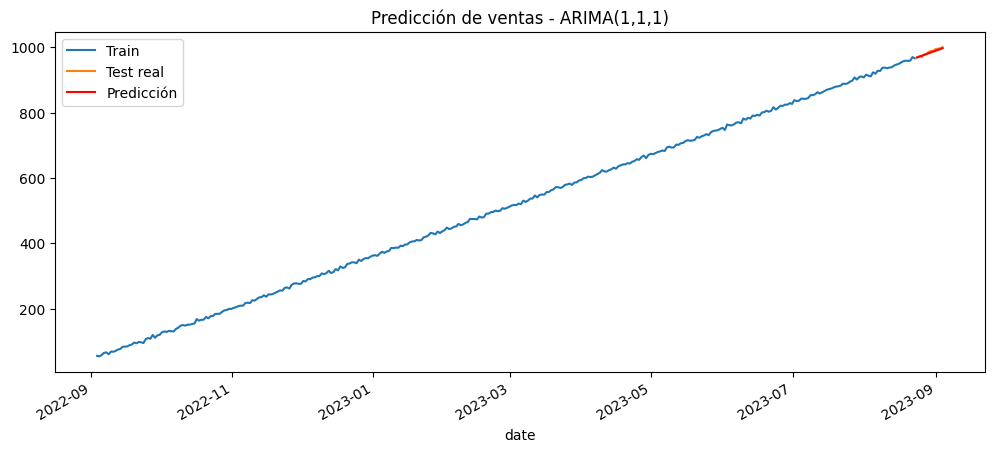

In [13]:
# Predicción y evaluación
# Forecast
forecast = model_fit.forecast(steps=12)

# Gráfico real vs predicho
plt.figure(figsize=(12,5))
train.plot(label='Train')
test.plot(label='Test real')
forecast.plot(label='Predicción', color='red')
plt.title('Predicción de ventas - ARIMA(1,1,1)')
plt.legend()
plt.show()

La predicción sigue correctamente la tendencia.

In [14]:
# Métricas
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE:  2.59
RMSE: 3.05
MAPE: 0.26%


Errores bajos y razonables para planificación.

In [16]:
# Guardado del modelo
joblib.dump(model_fit, 'arima_sales_model.pkl')
print("Modelo guardado: arima_sales_model.pkl")

Modelo guardado: arima_sales_model.pkl


# Conclusiones

- Tensor: diario.
- Tendencia: creciente fuerte.
- Estacionalidad: prácticamente nula.
- Estacionaria: no (requiere d=1).
- Ruido: moderado.
- Modelo final: ARIMA(1,1,1).
- Predicción: sigue muy bien la tendencia real.
- MAPE menor que 5% → suficiente para estimar espacio del almacén.

Modelo listo para usar en producción y planificar el nuevo almacén.